### Seleção de Portfolio:
Para construir os portifolios, deve se levar em consideração os critérios de seleção de ativos, e ranqueamento de ordem das ações.

### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from dateutil.relativedelta import relativedelta

In [2]:
#lendo os fatores:
factors = pd.read_csv("../data/risk_factors/factors.csv",index_col=None)
# ajustando os tipos das colunas:
factors['date'] = pd.to_datetime(factors['date'])
# factors['date'] = factors['date'].dt.strftime("%Y/%m/%d")
columns_to_float = factors.columns[1:]
factors[columns_to_float] = factors[columns_to_float].astype(float)
display(factors.head())


,date,Rm_minus_Rf,HML,IML,SMB,WML,Risk_free
0,2001-01-02,0.006601,0.065490,0.014109,0.000524,-0.006308,0.000579
1,2001-01-03,0.062427,0.009390,0.004510,0.005390,-0.028644,0.000577
2,2001-01-04,-0.000310,-0.002327,-0.009227,0.006690,-0.000946,0.000574
3,2001-01-05,-0.012839,-0.002397,0.025124,0.003523,0.005985,0.000573
4,2001-01-08,0.003982,0.001948,-0.001175,0.007883,-0.004099,0.000573


Text(0.5, 1.0, 'Average returns over time of common factors')

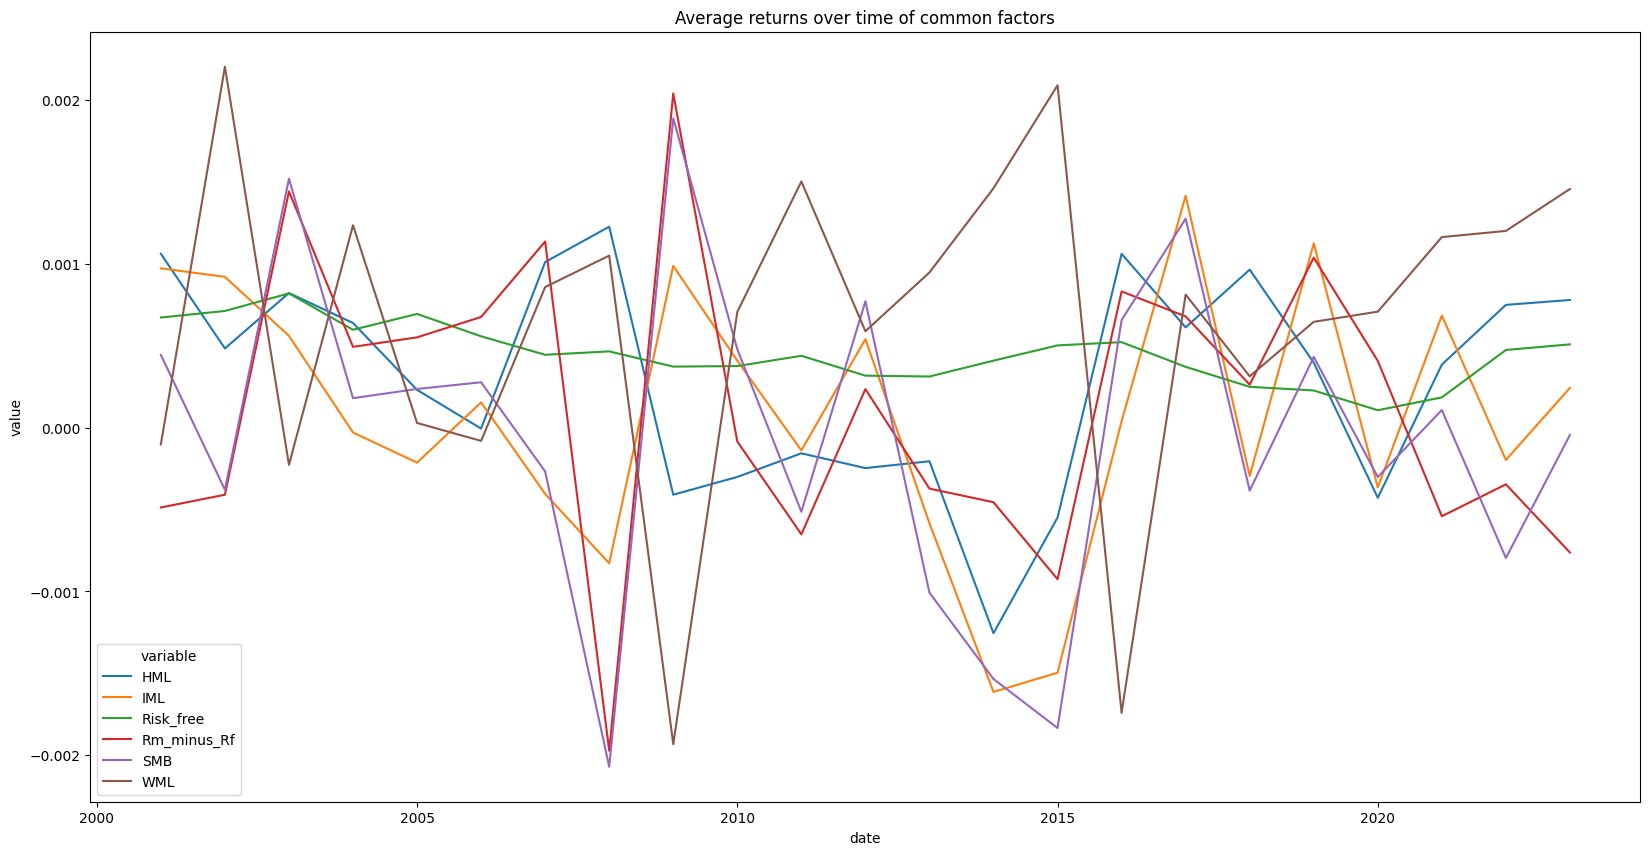

In [3]:
temp_factors = factors.copy()

temp_factors['date'] = temp_factors['date'].dt.year
temp_factors = pd.melt(temp_factors, id_vars = 'date')
temp_factors = temp_factors.groupby(['date','variable']).mean().reset_index()
# increase the size of the plot:
lineplot = sns.lineplot(x='date',y='value',hue='variable', data = temp_factors)
lineplot.figure.set_size_inches(20, 10)
# lineplot.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.)
lineplot.set_title('Average returns over time of common factors')

In [4]:
# vamos ver como os fatores se comportam em um portfolio:
# A função nos permite escolher uma data de início para o portfolio

def plot_cumulative_performance(df, start_date = None):

  # this function will plot cumulative performance for any wide dataframe of returns (e.g. index is date, columns are assets/factor)
  # optional: you can pass the start date in %m/%d/%y format e.g. '1/1/1995', '12/15/2000'
  # if you don't pass a start date, it will use the whole sample

  cumul_returns = (1+df.set_index('date')).cumprod()

  if start_date is None:
    start_date = cumul_returns.index.min()
  else:
    start_date = datetime.strptime(start_date, '%d/%m/%Y')
    cumul_returns = cumul_returns.loc[cumul_returns.index >= start_date]

  first_line = pd.DataFrame([[1. for col in cumul_returns.columns]],
                            columns = cumul_returns.columns,
                            index = [start_date - relativedelta(months=1)])

  cumul_returns = pd.concat([first_line,cumul_returns])

  return cumul_returns.plot(title = f'Cumulative factor performance since {start_date.strftime("%B %Y")}')


<Axes: title={'center': 'Cumulative factor performance since January 2001'}>

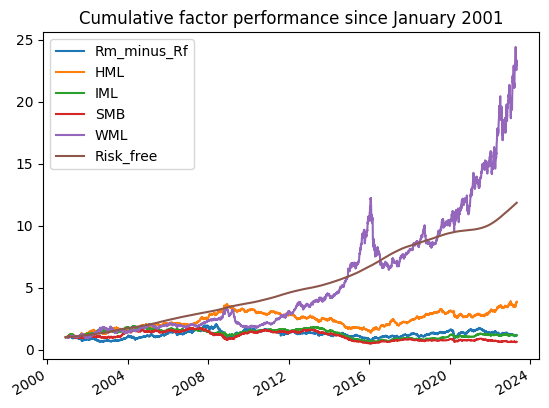

In [5]:
plot_cumulative_performance(factors)

In [6]:
ibov = pd.read_csv("../data/IBOV.csv",index_col=None)
display(ibov.head())
# reality check:
# Número de tickers únicos no ibov:
display(f'Number of unique tickers in ibov: {ibov["ticker"].nunique()}')
# Número de datas únicas no ibov:
display(f'Number of unique dates in ibov: {ibov["data_da_analise"].nunique()}')
# ajustar os nomes e tipos das colunas:
ibov['data_da_analise'] = pd.to_datetime(ibov['data_da_analise'])
ibov['ticker'] = ibov['ticker'].astype(str)
#renomear as colunas:
ibov = ibov.rename(columns={
    'data_da_analise':'date',
    'patrimonio_liquido':'PL',
    'quant_on_pn':'qnt',
    "retorno12_meses":"ret12m",
    "retorno6_meses":"ret6m",
    "retorno3_meses":"ret3m",
    "retorno1_mes":"ret1m",
    "ebit12_meses":"ebit12m",
    "nome_da_empresa":"name",
    "preco_de_fechamento":"closed_price"})

,ticker,nome_da_empresa,data_da_analise,patrimonio_liquido,quant_on_pn,ebit12_meses,preco_de_fechamento,ativo_total,fator_cotacao,retorno12_meses,retorno6_meses,retorno3_meses,retorno1_mes
0,ABEV3,AMBEV S/A,29/12/2022,86436867000,15753833000,18412913000,"14,52",135466722000,1,"-0,875125319484","14,0675796695","-1,64056836687","-3,98834374499"
1,ALPA4,ALPARGATAS,29/12/2022,5512355000,683062222,23403000,"15,08",8127527000,1,"-59,0849419223","-21,2121212121","-29,1020216264","-9,97014925374"
2,AMER3,AMERICANAS,29/12/2022,14705555000,909774507,1165519000,"9,65",47084128000,1,"-68,8323426225","-28,145941921","-43,168433451","-8,61742424235"
3,ARZZ3,AREZZO CO,29/12/2022,2741961000,110186077,493801000,"78,25",5131922000,1,"4,44070390573","14,6957238286","-19,6763218269","-11,748876086"
4,ASAI3,ASSAI,29/12/2022,3980000000,1350256000,2896000000,"19,47",39089000000,1,"51,7402976037","36,7008213743","11,1521778351","-2,70719595898"


'Number of unique tickers in ibov: 191'

'Number of unique dates in ibov: 23'

/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_3274/3924243084.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ibov['data_da_analise'] = pd.to_datetime(ibov['data_da_analise'])


In [7]:

# transforma valores [] em NaN:
ibov = ibov.replace('[]',np.nan)
# Remove commas from numeric columns and convert them to numeric values
numeric_columns = ['PL', 'qnt', 'ret12m','ret6m','ret3m','ret1m', 'closed_price', 'ebit12m', 'fator_cotacao','ativo_total']
for column in numeric_columns:
    if ibov[column].dtype == 'object':
        ibov[column] = ibov[column].str.replace(',', '.').astype(float)

display(ibov.head())

,ticker,name,date,PL,qnt,ebit12m,closed_price,ativo_total,fator_cotacao,ret12m,ret6m,ret3m,ret1m
0,ABEV3,AMBEV S/A,2022-12-29,8.643687e+10,1.575383e+10,18412913000,14.52,1.354667e+11,1,-0.875125,14.067580,-1.640568,-3.988344
1,ALPA4,ALPARGATAS,2022-12-29,5.512355e+09,6.830622e+08,23403000,15.08,8.127527e+09,1,-59.084942,-21.212121,-29.102022,-9.970149
2,AMER3,AMERICANAS,2022-12-29,1.470556e+10,9.097745e+08,1165519000,9.65,4.708413e+10,1,-68.832343,-28.145942,-43.168433,-8.617424
3,ARZZ3,AREZZO CO,2022-12-29,2.741961e+09,1.101861e+08,493801000,78.25,5.131922e+09,1,4.440704,14.695724,-19.676322,-11.748876
4,ASAI3,ASSAI,2022-12-29,3.980000e+09,1.350256e+09,2896000000,19.47,3.908900e+10,1,51.740298,36.700821,11.152178,-2.707196


In [8]:
from portfolio import *
portfolio = Portifolio(ibov)

In [9]:
ibov.dtypes

ticker                   object
name                     object
date             datetime64[ns]
PL                      float64
qnt                     float64
ebit12m                   int64
closed_price            float64
ativo_total             float64
fator_cotacao             int64
ret12m                  float64
ret6m                   float64
ret3m                   float64
ret1m                   float64
VM                      float64
dtype: object

In [10]:
portfolio.dataframe.dtypes

ticker                   object
name                     object
date             datetime64[ns]
PL                      float64
qnt                     float64
ebit12m                   int64
closed_price            float64
ativo_total             float64
fator_cotacao             int64
ret12m                  float64
ret6m                   float64
ret3m                   float64
ret1m                   float64
VM                      float64
dtype: object

In [11]:
momentum = portfolio.build_momentum_portfolio()

In [12]:
portfolio.momentum.head()

,ticker,name,date,PL,qnt,ebit12m,closed_price,ativo_total,fator_cotacao,ret12m,ret6m,ret3m,ret1m,VM
0,AMBV4,AMBEV,2000-12-27,3.215728e+10,3.132287e+09,14514899000,488.01,5.175332e+10,1000,150.419809,70.493224,21.450159,15.207394,1.528587e+15
1,PETR3,PETROBRAS,2000-12-27,4.034050e+11,1.304450e+10,289398000000,47.61,9.785770e+11,1,39.456780,-7.553398,-13.750000,-8.793103,6.210485e+11
2,TRPL4,TRAN PAULIST,2000-12-27,1.719823e+10,6.588833e+08,3148043000,6.43,3.374970e+10,1000,22.543553,-8.679873,-21.108056,1.621483,4.236620e+12
3,TNLP3,TELEMAR,2000-12-27,2.518232e+10,4.766620e+08,2243839000,32.31,7.769670e+10,1000,15.683653,-7.685714,-1.433801,11.799308,1.540095e+13
4,ITSA4,ITAUSA,2000-12-27,7.741900e+10,9.701410e+09,3061000000,1.87,9.787500e+10,1,11.192139,13.380587,1.531596,17.628069,1.814164e+10


In [13]:
value = portfolio.build_value_portfolio()